## 4.3 Decentralized Exact Diffusion

### 4.3.1 Problem and decentralized gradient descent

### 4.3.2 Decentralized exact diffusion

### 4.3.3 Convergence properties

### 4.3.4 An example: least-square problem

In this section, we will show a demo on how to solve a decentralized least-square problem with Exact Diffusion. Suppose $n$ computing nodes collaborate to solve the following problem:

$$\min_x \quad \frac{1}{n}\sum_{i=1}^n \|A_i x - b_i\|^2$$

where $\{A_i, b_i\}$ are local data held in node $i$.


#### 4.3.4.1 Set up Environment

In [33]:
import ipyparallel as ipp
rc = ipp.Client(profile='bluefog')
dview = rc[:] # A DirectView of all engines
dview.block=True

In [34]:
%%px
import numpy as np
import bluefog.torch as bf
import torch
from bluefog.common import topology_util
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

bf.init()

#### 4.3.4.2 Generate local data $A_i$ and $b_i$

In [35]:
%%px

def generate_data(m, n):
    
    A = torch.randn(m, n).to(torch.double)
    x_o = torch.randn(n, 1).to(torch.double)
    ns = 0.1*torch.randn(m, 1).to(torch.double)
    b = A.mm(x_o) + ns
        
    return A, b

In [36]:
%%px

def distributed_grad_descent(A, b, maxite=5000, alpha=1e-1):

    x_opt = torch.zeros(n, 1, dtype=torch.double)

    for _ in range(maxite):
        # calculate local gradient 
        grad_local = A.t().mm(A.mm(x_opt) - b)
        
        # global gradient
        grad = bf.allreduce(grad_local, name='gradient')

        # distributed gradient descent
        x_opt = x_opt - alpha*grad

    grad_local = A.t().mm(A.mm(x_opt) - b)
    grad = bf.allreduce(grad_local, name='gradient')  # global gradient

    # evaluate the convergence of distributed gradient descent
    # the norm of global gradient is expected to 0 (optimality condition)
    global_grad_norm = torch.norm(grad, p=2)
    if bf.rank() == 0:
        print("[Distributed Grad Descent] Rank {}: global gradient norm: {}".format(bf.rank(), global_grad_norm))

    return x_opt

In [37]:
%%px

m, n = 2000, 25
A, b = generate_data(m, n)
x_opt = distributed_grad_descent(A, b, maxite=1000, alpha=1e-4)

[stdout:0] [Distributed Grad Descent] Rank 0: global gradient norm: 8.09083253944933e-13


#### 4.3.4.3 One step of Exact Diffusion

In [38]:
%%px

def exact_diffusion_one_step(x, A, b, pre_psi, alpha=1e-2):
    grad = A.t().mm(A.mm(x)-b)
    psi = x-alpha*grad
    phi = psi + x - pre_psi
    x_opt = bf.neighbor_allreduce(phi)
    return x_opt, psi

In [39]:
%%px

# Set topology as ring topology.
G = topology_util.RingGraph(bf.size())
bf.set_topology(G)

max_iter = 200

alpha = 2e-4

x = torch.zeros(n, 1, dtype=torch.double)     # Initialize x for exact diffusion
psi = x
rel_error = torch.zeros((max_iter, 1))

for ite in range(max_iter):
    if ite%10 == 0:
        if bf.rank() == 0:
            print('Progress {}/{}'.format(ite, max_iter))
    x, psi= exact_diffusion_one_step(x, A, b, psi, alpha=alpha)
    rel_error[ite] = torch.norm(x-x_opt, p=2)/torch.norm(x_opt,p=2)   

[stdout:0] 
Progress 0/200
Progress 10/200
Progress 20/200
Progress 30/200
Progress 40/200
Progress 50/200
Progress 60/200
Progress 70/200
Progress 80/200
Progress 90/200
Progress 100/200
Progress 110/200
Progress 120/200
Progress 130/200
Progress 140/200
Progress 150/200
Progress 160/200
Progress 170/200
Progress 180/200
Progress 190/200


In [40]:
# collect relative error
rel_error = dview.pull('rel_error', block=True)
rel_error_avg = sum(rel_error)/len(rc.ids)

Text(0, 0.5, 'Relative error')

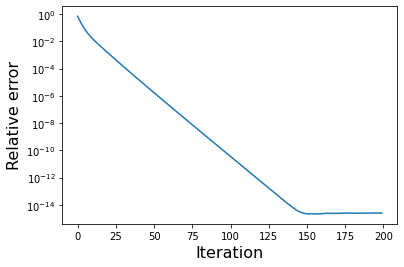

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.semilogy(rel_error_avg)

plt.xlabel('Iteration', fontsize=16)
plt.ylabel('Relative error', fontsize=16)